In [1]:
PROCESSES_COUNT = 20

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, model_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

folder_filename = lambda run_id: f"../results/RUNDATA_R26_{run_id}"

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    tallydf=sp.tallies[2].get_pandas_dataframe() # Tally 2 is in the moderator
    tallydf_flux=tallydf[tallydf['score']=='flux']
    energy=(tallydf_flux['energy low [eV]']+tallydf_flux['energy high [eV]'])/2

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path,
        "energy": energy,
        "flux": tallydf_flux["mean"],
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 6 result folders
Loading data with 20 processes...


100%|██████████| 6/6 [00:00<00:00,  8.77it/s]


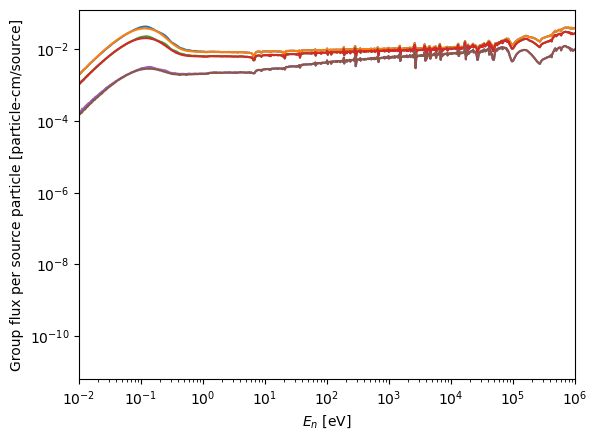

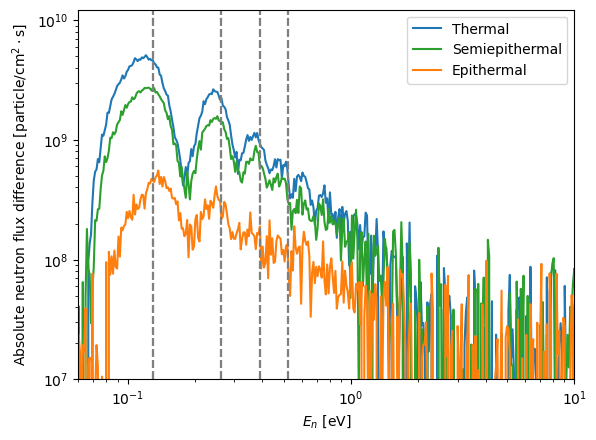

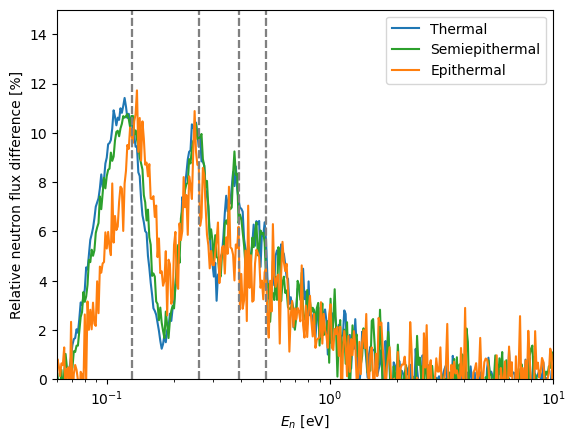

In [25]:
# May 14 2023 - Plot flux with its uncertainty


colors = ["tab:blue", "tab:green", "tab:orange"]
for i, REACTOR_MODEL in enumerate([model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR, model_tools.EPITHERMAL_REACTOR]):
# for REACTOR_MODEL in [model_tools.THERMAL_REACTOR, model_tools.SEMIEPITHERMAL_REACTOR]:
        
    plt.figure(1)
    df = pd.DataFrame(columns=["energy", "flux", "use_thermal_scattering"])
    results_this_reactor = [result for result in results if result["reactor_model"] == REACTOR_MODEL]
    for result in results_this_reactor:
        energy = result["energy"]
        flux = result["flux"]
        use_thermal_scattering = result["use_thermal_scattering"]
        
        plt.loglog(energy, flux, label=f"use_thermal_scattering={use_thermal_scattering}")

        if use_thermal_scattering == True:
            flux_themal_scattering = flux
        else:
            flux_no_thermal_scattering = flux


    # sns.lineplot(data=df, x="energy", y="flux", hue="use_thermal_scattering")
    ax = plt.gca()
    plt.xlim(1e-2, 1e6)
    # plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("$E_n$ [eV]")
    plt.ylabel('Group flux per source particle [particle-cm/source]')

    plt.savefig(f"TSL_flux_thermal_R26.pdf")


    factors_for_tallies = { # From plot_flux.ipynb in R20
        1: 1052409913999.0562,
        2: 1127357578925.364,
        3: 1477382811822.8477
    }

    factor = factors_for_tallies[i+1]

    # Plot difference (bot absolute and relative) between flux with and without thermal scattering
    plt.figure(2)
    plt.loglog(energy, (flux_themal_scattering - flux_no_thermal_scattering)*factor, label=REACTOR_MODEL.capitalize(), color=colors[i])  # "Absolute difference (TSL - no TSL)"
    # plt.xlim(1e-2, 1e6)
    plt.xlim(6e-2, 1e1)
    plt.ylim(bottom=1e7)

    for j in range(4):
        plt.vlines(0.13*j, 1e7, 1e13, linestyles="dashed", color="gray")

    plt.legend()
    plt.xlabel("$E_n$ [eV]")
    plt.ylabel('Absolute neutron flux difference [particle/cm$^2\cdot$s]')
    plt.savefig(f"TSL_flux_difference_absolute.pdf")

    plt.figure(3)
    plt.semilogx(energy, 100*((flux_themal_scattering - flux_no_thermal_scattering) / flux_themal_scattering), label=REACTOR_MODEL.capitalize(), color=colors[i]) # "Norm of Relative difference (TSL - no TSL)/TSL"
    # plt.xlim(1e-2, 1e6)
    plt.xlim(6e-2, 1e1)
    plt.ylim(0, 15)

    for j in range(4):
        plt.vlines(0.13*j, 0, 15, linestyles="dashed", color="gray")
    
    plt.legend()
    plt.xlabel("$E_n$ [eV]")
    plt.ylabel('Relative neutron flux difference [%]')
    plt.savefig(f"TSL_flux_difference_relative.pdf")

